___
## Ciência dos Dados - PROJETO 3 - INSPER

___
#### Victor Arruda Niubó

#### Giovanni Pertence Cardoso dos Santos

#### Gustavo Schlieper Tessitore

#### Leonardo Cesari Costa
___

# Previsão da quantidade de views

___

## 1. INTRODUÇÃO

O objetivo do projeto é estimar a quantidade de visualizações que um vídeo terá com base no título, horário de publicação e as tags atribuidas aos vídeos.

___
## 2. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

In [1]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats
import itertools
import math
import json
import os
from scipy import stats
from scipy.stats import norm

In [2]:
#remove mesagens de aviso do Pandas
pd.options.mode.chained_assignment = None
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/giovannid.santos/Documents/Insper/3_Semestre/CDADOS-DP/cdados_dp/P3


### BASE DE DADOS

In [3]:
# Base de dados dos videos em destaque do youtube US
you_data = pd.read_csv("USvideos.csv")

you_data.drop_duplicates(subset = 'video_id', keep = 'last', inplace = True)

# jason que contém a relação id - categoria
ids = json.loads(open('US_category_id.json').read())


# filtro das variáveis de interesse
you_analysis = you_data.loc[you_data.views|you_data.title|you_data.tags|you_data.category_id,\
                           ['views', 'title', 'tags', 'category_id']]
you_analysis = you_analysis.reset_index().drop('index',axis=1)

# you_analysis = you_analytics.iloc[0:int(you_analytics.index[-1]*0.75), :]
# you_test = you_analytics.iloc[int(you_analytics.index[-1]*0.75):, :]


In [4]:
# separação da string das tags em uma lista de strings
tags_split = you_analysis.tags.str.split(pat = '|')
you_analysis['tags_split'] = tags_split
you_analysis.head()
you_ifn = you_analysis.copy()

In [5]:
# Junta todas as strings em uma lista só para pder fazer um value_counts() e criar um
# dataframe com as tags e as frquencias de cada uma
merged = list(itertools.chain(*you_analysis.tags_split))
contador = pd.DataFrame({'col':merged})
limpino = contador[contador.col != '[none]']
dfl = limpino.col.value_counts().rename_axis('tags').reset_index(name='counts')
dfl = dfl[(dfl['counts'])> 10]

In [6]:
%store dfl
%store you_data

Stored 'dfl' (DataFrame)
Stored 'you_data' (DataFrame)


In [7]:
## Separa as linhas que contém certa tag
for ind,data in tqdm(dfl.iterrows(), total=dfl.shape[0]):
    var_df = you_analysis[you_analysis['tags'].str.contains(data['tags'])]
    x = list(var_df.index)
    you_analysis[data['tags']+'_freq'] = 0
    you_analysis.loc[x,[data['tags']+'_freq']] = data['counts']
    
# var_df = you_analysis['tags'].str.contains(dfl.tags[0])
# list(var_df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


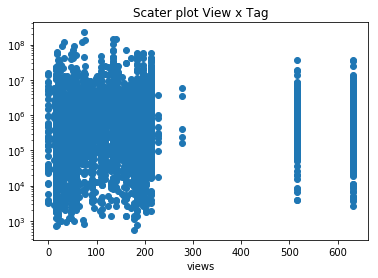

In [8]:
# Cria dataframe das views e frequência máxima
banana = pd.DataFrame()
banana['views'] = you_analysis['views']
banana['max_freq'] = you_analysis.iloc[:,5:].max(axis=1)

# Plota scatter 
ax = plt.gca()
ax.scatter(banana.max_freq, banana.views)
ax.set_yscale('log')
ax.set_title('Scater plot View x Tag')
ax.set_xlabel('frequencia da tag')
ax.set_xlabel('views');

In [9]:
# Transpose no dataframe para poder usar .nlargest()
you_freqs = you_analysis.iloc[:,5:]
trans = you_freqs.T


In [10]:
#trans.rename(index=str, columns={e: "vid_{0}".format(e)})
%store trans
%store you_analysis
%store banana

Stored 'trans' (DataFrame)
Stored 'you_analysis' (DataFrame)
Stored 'banana' (DataFrame)


In [11]:
top3_sum = []
toto_sum = []
for ind, data in tqdm(you_freqs.iterrows(), total=you_freqs.shape[0]):
    top3_sum.append(data.nlargest(3).sum())
    toto_sum.append(data.sum())

In [12]:
you_ifn['top3_freq']=top3_sum
%store you_ifn

Stored 'you_ifn' (DataFrame)


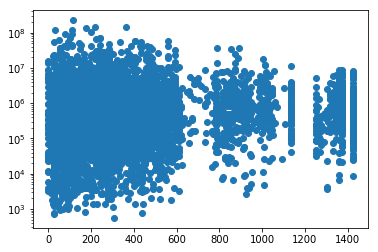

In [13]:
plt.gca().scatter(you_ifn.top3_freq, you_ifn.views)
plt.gca().set_yscale('log')

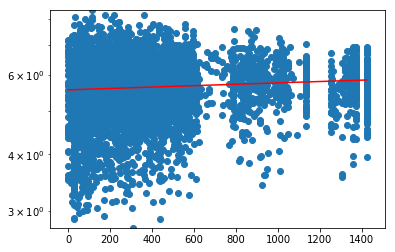

In [14]:
def Plot_line(x_dado, y_dado):

    x = x_dado
    y = y_dado

    yb = y.mean()
    xb = x.mean()

    Sxy = ((x -xb)*(y -yb)).sum()
    Sxx = ((x -xb)**2).sum()

    b1 = Sxy/Sxx
    b0 = yb - b1*xb

    x_v = np.linspace(x.min(), x.max(), 500)
    y_v = b0 + b1*x_v

    plt.plot(x_v,y_v, color="r") # resultados da regressão
    plt.scatter(x, y); # dados
    plt.gca().set_yscale('log')
    plt.ylim((y.min(),y.max()))
    
Plot_line(you_ifn.top3_freq, np.log10(you_ifn.views))

In [15]:
a = trans.copy().T.astype(str)
for i in tqdm(a.columns):
    a[i] = a[i].str.replace('[1-9][0-9]*','1')

In [16]:
a = a.astype(int)
n_tags = []
for ind,data in tqdm(a.iterrows(), total=a.shape[0]):
    n_tags.append(data.sum())

In [17]:
mean_freqs = []
for e in range(len(n_tags)):
    mean_freqs.append(toto_sum[e]/n_tags[e])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


### ANÁLISE DESCRITIVA

___
## C. MODELOS DE PREDIÇÃO

In [128]:
new_data = pd.DataFrame()
new_data['views'] = you_analysis['views']
new_data['top3_freq'] = top3_sum
new_data['n_tags'] = n_tags
new_data['mean_freqs'] = mean_freqs
new_data['funny'] = a['funny_freq']
new_data['comedy'] = a['comedy_freq']
new_data['humor'] = a['humor_freq']
new_data['music'] = a['music_freq']
new_data = new_data.dropna()

nd_treino = new_data.iloc[0:int(new_data.index[-1]*0.75), : ]
nd_teste = new_data.iloc[int(new_data.index[-1]*0.75):, : ]

X=new_data[['top3_freq','n_tags','mean_freqs']]
y=new_data['views']

X_treino,X_teste,y_treino,y_teste=train_test_split(X,y,test_size=.25,random_state=0)

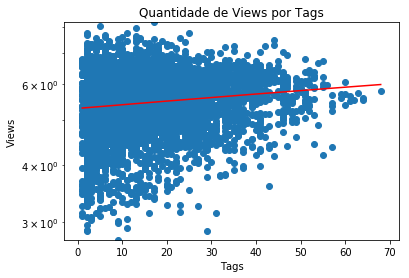

In [38]:
Plot_line(nd_treino.n_tags,np.log10(nd_treino.views))
plt.title('Quantidade de Views por Tags')
plt.xlabel('Tags')
plt.ylabel('Views');

,views,top3_freq,n_tags,mean_freqs,funny,comedy,humor,music
0,81377,409,45,46.533333,0,0,0,0


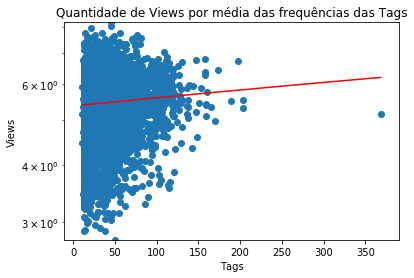

In [39]:
Plot_line(nd_treino.mean_freqs,np.log10(nd_treino.views))
plt.title('Quantidade de Views por média das frequências das Tags')
plt.xlabel('Tags')
plt.ylabel('Views');
nd_treino.head(1)

In [40]:
com_funny = []
sem_funny = []

com_comedy = []
sem_comedy = []

com_humor = []
sem_humor = []

com_music = []
sem_music = []

for i in new_data.iterrows():
    if i[1].funny == 1:
        com_funny.append(i[1].views)
    elif i[1].funny == 0:
        sem_funny.append(i[1].views)
        
    if i[1].comedy == 1:
        com_comedy.append(i[1].views)
    elif i[1].comedy == 0:
        sem_comedy.append(i[1].views)
        
    if i[1].humor == 1:
        com_humor.append(i[1].views)
    elif i[1].humor == 0:
        sem_humor.append(i[1].views)
        
    if i[1].music == 1:
        com_music.append(i[1].views)
    elif i[1].music == 0:
        sem_music.append(i[1].views)
        

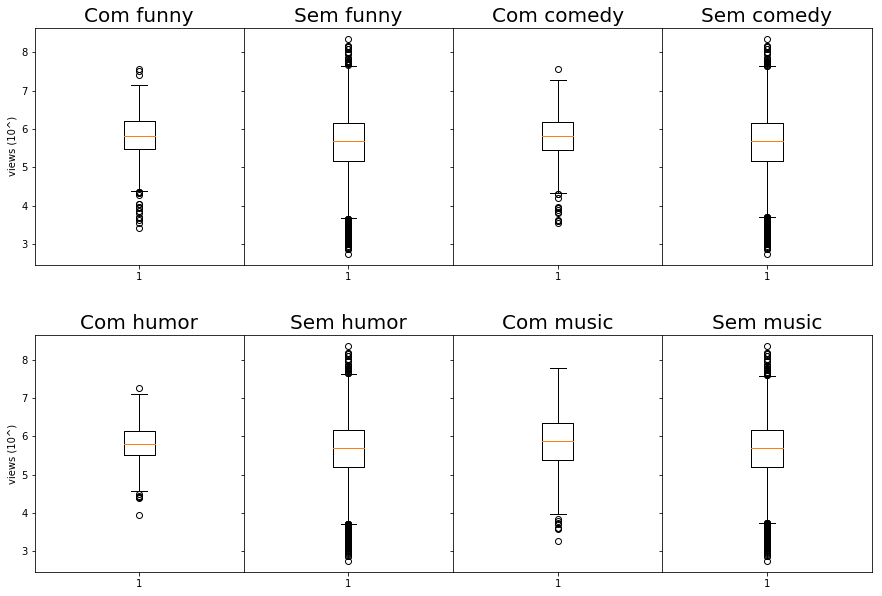

In [41]:
fig, axs = plt.subplots(2, 4, sharey='row', gridspec_kw={'hspace': 0.3, 'wspace': 0})
fig.set_size_inches(15, 10)

axs[0, 0].boxplot(np.log10(com_funny))
axs[0, 0].set_title('Com funny', fontsize= 20)
axs[0, 0].set_ylabel('views (10^)')
axs[0, 1].boxplot(np.log10(sem_funny))
axs[0, 1].set_title('Sem funny', fontsize= 20)

axs[0, 2].boxplot(np.log10(com_comedy))
axs[0, 2].set_title('Com comedy', fontsize= 20)
axs[0, 3].boxplot(np.log10(sem_comedy))
axs[0, 3].set_title('Sem comedy', fontsize= 20)

axs[1, 0].boxplot(np.log10(com_humor))
axs[1, 0].set_title('Com humor', fontsize= 20)
axs[1, 0].set_ylabel('views (10^)')
axs[1, 1].boxplot(np.log10(sem_humor))
axs[1, 1].set_title('Sem humor', fontsize= 20)

axs[1, 2].boxplot(np.log10(com_music))
axs[1, 2].set_title('Com music', fontsize= 20)
axs[1, 3].boxplot(np.log10(sem_music))
axs[1, 3].set_title('Sem music', fontsize= 20);


o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

In [124]:
lr = LinearRegression()
lr.fit(X_treino,y_treino)
y_pred=lr.predict(X_teste)
mean_squared_error(y_teste,y_pred)

67427161575827.04

o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

In [123]:
nd_treino.views.mean(),nd_teste.views.mean()

(1313638.7662420382, 3940555.726143791)

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [126]:
knn = KNeighborsRegressor(17)
knn.fit(X_treino,y_treino)
y_pred1 = knn.predict(X_teste)
mean_squared_error(y_teste,y_pred1)

67563413719301.63

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

In [133]:
Xs_tr = nd_treino.iloc[: , 1:4]
y_tr = nd_treino.views

Xs_ts = nd_teste.iloc[:, 1:4]

y_ts = nd_teste.views
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(Xs_tr, y_tr)

# Predicting a new result
y_pred2 = regressor.predict(Xs_ts)
mean_squared_error(y_ts, y_pred2)

149741633581020.56

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS